In [1]:
import tensorflow as tf
from pack_latest import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
import itertools

In [2]:
# create pandas dictionary
pd_dict = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}

In [3]:
# loop for reading the file overall store
for i in pd_dict:
    pd_dict[i] = pd.read_csv('../../dataset/egg/multi_stores/combine_' + i + '_egg_2016_2017.csv', delimiter='\t')

In [4]:
# remove pandas 'unnamed: 0' column
for i in pd_dict:
    pd_dict[i] = pd_dict[i].drop('Unnamed: 0', axis=1)

In [5]:
# create new features
# 1. Quantity difference in a single day
# 2. Quantity difference in last two days
# 3. Quantity difference in last three days
# 4. Price difference in a single day
# 5. Price difference in last two days
# 6. Price difference in last three days
# 7. Quantity Level
for i in pd_dict:
    pd_dict[i]['Quantity_dif'] = pd_dict[i]['Quantity'].diff()
    pd_dict[i]['Quantity_dif2'] = pd_dict[i]['Quantity'].diff(periods=2)
    pd_dict[i]['Quantity_dif3'] = pd_dict[i]['Quantity'].diff(periods=3)

    pd_dict[i]['Price_dif'] = pd_dict[i]['Price'].diff()
    pd_dict[i]['Price_dif2'] = pd_dict[i]['Price'].diff(periods=2)
    pd_dict[i]['Price_dif3'] = pd_dict[i]['Price'].diff(periods=3)
    
    pd_dict[i]['Level'] = pd_dict[i]['Quantity'].rolling(7).mean()
    
    pd_dict[i] = pd_dict[i][7:]
pd_dict['lbkbls'].head()

,Date,EncodedDay,EncodedDay_week,Is_holiday,Is_weekend,Month,Price,Quantity,Year,EncodedDay_multipleyear,Quantity_dif,Quantity_dif2,Quantity_dif3,Price_dif,Price_dif2,Price_dif3,Level
7,8.0,160,3.0,0.0,0.0,6.0,23200.0,161.394,2016.0,160.0,-80.708,-73.082,-640.534,119.480519,400.000000,428.513514,366.379143
8,9.0,161,4.0,0.0,0.0,6.0,23700.0,148.556,2016.0,161.0,-12.838,-93.546,-85.920,500.000000,619.480519,900.000000,351.324857
9,10.0,162,5.0,0.0,0.0,6.0,23700.0,163.678,2016.0,162.0,15.122,2.284,-78.424,0.000000,500.000000,619.480519,333.237429
10,11.0,163,6.0,0.0,1.0,6.0,21800.0,280.944,2016.0,163.0,117.266,132.388,119.550,-1900.000000,-1900.000000,-1400.000000,290.439714
11,12.0,164,7.0,0.0,1.0,6.0,21800.0,366.542,2016.0,164.0,85.598,202.864,217.986,0.000000,-1900.000000,-1900.000000,228.241714


In [6]:
# Neural Network will not work well if the data to high
# normalize it to nearly 1 or -1

# normalize the quantity and level
from sklearn.preprocessing import PowerTransformer
q_pt = {}
l_pt = {}
for i in pd_dict:
    q_pt[i] = PowerTransformer()
    l_pt[i] = PowerTransformer()

# normalize others    
price_scale_max = 30000.0
price_scale_min = 15000.0
pricedif_scale = 1000.0
quantitydif_scale = 500.0
week_scale = 7
date_scale = 31
decay = 10

In [7]:
for i in pd_dict:
    
    # prepare price data
    #price_np = np.array(pd_dict[i]['Price'])
    #price_np = np.abs(price_np.reshape((price_np.shape[0], 1)))
    #price_np += decay
    
    # prepare quantity data
    quantity_np = np.array(pd_dict[i]['Quantity'])
    quantity_np = np.abs(quantity_np.reshape((quantity_np.shape[0], 1)))
    quantity_np += decay
    
    # prepare quantity data
    level_np = np.array(pd_dict[i]['Level'])
    level_np = np.abs(level_np.reshape((level_np.shape[0], 1)))
    level_np += decay
    
    # fit and scale price data
    #p_pt[i].fit(price_np)
    #res = p_pt[i].transform(price_np)
    #res = res.reshape((res.shape[0],))
    #pd_dict[i]['Price'] = res
    pd_dict[i]['Price'] = (pd_dict[i]['Price'] - price_scale_min)/(price_scale_max - price_scale_min)
    
    # fit and scale quantity data
    q_pt[i].fit(quantity_np)
    res = q_pt[i].transform(quantity_np)
    res = res.reshape((res.shape[0],))
    pd_dict[i]['Quantity'] = res
    
    # fit and transform level data
    l_pt[i].fit(level_np)
    res = l_pt[i].transform(level_np)
    res = res.reshape((res.shape[0],))
    pd_dict[i]['Level'] = res
    
    # normalize other features
    pd_dict[i]['Quantity_dif'] =  pd_dict[i]['Quantity_dif']/quantitydif_scale
    pd_dict[i]['Quantity_dif2'] = pd_dict[i]['Quantity_dif2']/quantitydif_scale 
    pd_dict[i]['Quantity_dif3'] = pd_dict[i]['Quantity_dif3']/quantitydif_scale

    pd_dict[i]['Price_dif'] = pd_dict[i]['Price_dif']/pricedif_scale
    pd_dict[i]['Price_dif2'] = pd_dict[i]['Price_dif2']/pricedif_scale
    pd_dict[i]['Price_dif3'] = pd_dict[i]['Price_dif3']/pricedif_scale
    
    pd_dict[i]['EncodedDay_week'] = pd_dict[i]['EncodedDay_week']/week_scale
    pd_dict[i]['Date'] = pd_dict[i]['Date']/date_scale

In [8]:
# for each store, drop and reset index
for i in pd_dict:
     pd_dict[i] = pd_dict[i].reset_index(drop=True)

In [9]:
# check the value
pd_dict['lbkbls'].head()

,Date,EncodedDay,EncodedDay_week,Is_holiday,Is_weekend,Month,Price,Quantity,Year,EncodedDay_multipleyear,Quantity_dif,Quantity_dif2,Quantity_dif3,Price_dif,Price_dif2,Price_dif3,Level
0,0.258065,160,0.428571,0.0,0.0,6.0,0.546667,-0.572424,2016.0,160.0,-0.161416,-0.146164,-1.281068,0.119481,0.400000,0.428514,2.466507
1,0.290323,161,0.571429,0.0,0.0,6.0,0.580000,-0.801601,2016.0,161.0,-0.025676,-0.187092,-0.171840,0.500000,0.619481,0.900000,2.312798
2,0.322581,162,0.714286,0.0,0.0,6.0,0.580000,-0.534009,2016.0,162.0,0.030244,0.004568,-0.156848,0.000000,0.500000,0.619481,2.110340
3,0.354839,163,0.857143,0.0,1.0,6.0,0.453333,0.845364,2016.0,163.0,0.234532,0.264776,0.239100,-1.900000,-1.900000,-1.400000,1.534540
4,0.387097,164,1.000000,0.0,1.0,6.0,0.453333,1.455188,2016.0,164.0,0.171196,0.405728,0.435972,0.000000,-1.900000,-1.900000,0.330500


In [10]:
# create target and feature dictionary
targets = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}
features = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}

In [11]:
# only select usable feaature
# 'Price', 'Quantity', 'Quantity_dif', 'Quantity_dif2', 'Quantity_dif3'
# 'Price_dif', 'Price_dif2', 'Price_dif3', 'Level',
# 'Date', 'Is_holiday', 'Is_weekend', 'EncodedDay_week'
for i in pd_dict:
    targets[i] = pd_dict[i]['Quantity'][7:]
    features[i] = pd_dict[i][['Price', 'Quantity', 'Quantity_dif', 'Quantity_dif2', 'Quantity_dif3', 
                     'Price_dif', 'Price_dif2', 'Price_dif3', 'Level',
                     'Date', 'Is_holiday', 'Is_weekend', 'EncodedDay_week']][:-7]

In [12]:
from feature_engineering_utils.data_handling import *

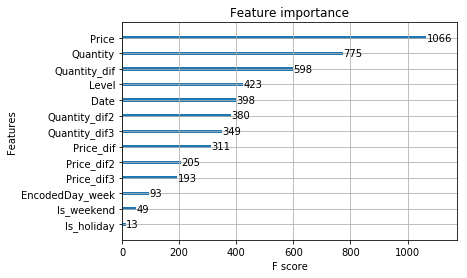

In [13]:
plot = get_feture_importance(features['lbkbls'], targets['lbkbls'], code='regression')
plt.show()

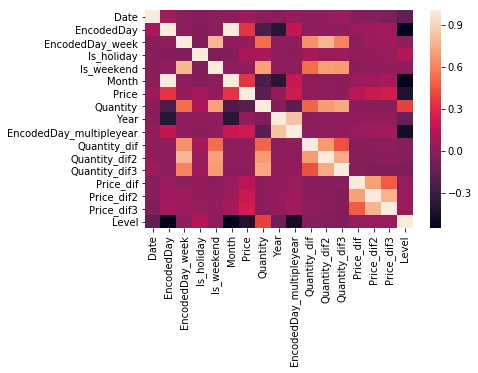

In [14]:
import seaborn as sns
corr = pd_dict['lbkbls'].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

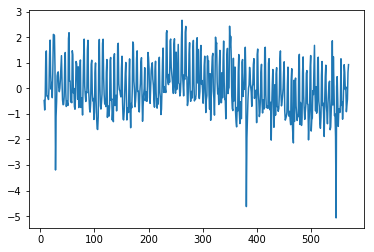

In [15]:
plt.plot(targets['lbkbls'])
plt.show()

In [16]:
# create target and features numpy dictionary
target_np = {'bmlbks': None, 'bsdtgr':None, 'cpkmas':None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua':None, 'mllind': None, 'pmthju':None, 'tmnmni': None, 
           'tmnplm': None}
features_np = {'bmlbks': None, 'bsdtgr':None, 'cpkmas':None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua':None, 'mllind': None, 'pmthju':None, 'tmnmni': None, 
           'tmnplm': None}

In [17]:
##### Convert feature and target to numpy array
for i in pd_dict:
    features_np[i] = features[i].as_matrix().astype(float)
    target_np[i] = targets[i].as_matrix().astype(float)
    target_np[i] = target_np[i].reshape(len(target_np[i]), 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [18]:
# create each store dictionary for training and testing
x_train = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}
y_train = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}
x_test = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}
y_test = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}

In [19]:
# set 80% for training and 20% for testing
border = int(0.8 * len(features_np['lbkbls']))

for i in pd_dict:
    x_train[i], y_train[i] = features_np[i][:border], target_np[i][:border]
    x_test[i], y_test[i] = features_np[i][border:], target_np[i][border:]
    print (x_train[i].shape, y_train[i].shape, x_test[i].shape, y_test[i].shape)

(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (115, 13) (115, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (451, 1) (113, 13) (113, 1)
(451, 13) (4

In [20]:
# the number of input
num_x_signals = 13
# the number of output
num_y_signals = 1
# define the batch size
batch_size = 1
# define the sequence length
sequence_length = 42

In [21]:
def train_batch_generator(batch_size, sequence_length, x_feature, y_feature):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    idx = 0
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            #idx = np.random.randint(len(x_feature) - sequence_length)
            if idx >= (len(x_feature) - sequence_length):
                idx = 0
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_feature[idx:idx+sequence_length]
            y_batch[i] = y_feature[idx:idx+sequence_length]
            
            idx += 1
        yield (x_batch, y_batch)

In [22]:
def val_batch_generator(batch_size, sequence_length, x_feature, y_feature):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    idx = 0
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            #idx = np.random.randint(len(x_feature) - sequence_length)
            if idx >= (len(x_feature) - sequence_length):
                idx = 0
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_feature[idx:idx+sequence_length]
            y_batch[i] = y_feature[idx:idx+sequence_length]
            idx += 1
            
        yield (x_batch, y_batch)

In [23]:
train_generator = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}
test_generator = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}

In [24]:
for i in pd_dict:
    train_generator[i] = train_batch_generator(batch_size = batch_size,
                                               sequence_length = sequence_length, 
                                               x_feature = x_train[i],
                                               y_feature = y_train[i])
    test_generator[i] = val_batch_generator(batch_size=batch_size,
                                         sequence_length=sequence_length,
                                         x_feature = x_test[i],
                                         y_feature = y_test[i])

In [25]:
train_x_batch, train_y_batch = next(train_generator['lbkbls'])
train_x_batch2, train_y_batch2 = next(train_generator['dpkrgn'])
train_x_batch3, train_y_batch3 = next(train_generator['kmtjti'])

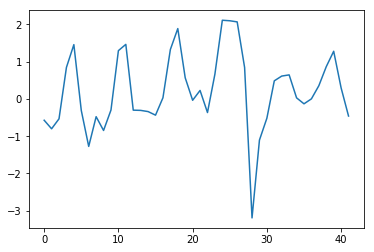

In [26]:
batch = 0   # First sequence in the batch.
signal = 1  # First signal from the 20 input-signals.
seq = train_x_batch[batch, :, signal]
plt.plot(seq)

In [27]:
residualLSTM = SimpleSquenceLSTM(batch_size = batch_size,\
                            num_lstm_cell = sequence_length, \
                            input_feature_num = num_x_signals, \
                            output_feature_num = num_y_signals, \
                            memory_feature_num = 200, \
                            hidden_neuron_num = 50, \
                            dropout_val=0.90, \
                            with_residual = False, \
                            residual_season=1, \
                            return_memmory=False)

In [28]:
out, variables = residualLSTM.build_net()

In [29]:
cost = residualLSTM.mse_loss(out)

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost, var_list=variables)

In [31]:
saver = tf.train.Saver()
save_path = 'model/lstm_ms_100hiddenneurons'
session = tf.Session()
session.run(tf.global_variables_initializer())

In [32]:
train_losses = []
test_losses = []

In [37]:
def test_model():
    tmp_test_losses = []
    
    for j in pd_dict:
        if j == 'pdkgde':
            continue
            
        # take random 100 times and average it
        for k in range(78):
            test_x_batch, test_y_batch = next(test_generator[j])
            test_feed_dict = {}
            test_feed_dict[residualLSTM.input_feature_placeholder] = test_x_batch
            test_feed_dict[residualLSTM.output] = test_y_batch
            # get test loss
            test_loss = session.run(cost, feed_dict=test_feed_dict)
            tmp_test_losses.append(test_loss)
            
    tmp_test_losses = np.array(tmp_test_losses)
    test_loss = sum(tmp_test_losses)/(len(tmp_test_losses + 0.0001))
    return test_loss


def optimize(num_iterations):
    best_loss = 10
    
    for i in range(num_iterations):
        
        for j in pd_dict:
            if j == 'pdkgde':
                continue
            for k in range(15):
                sign = '-'
                
                tmp_train_losses = []
                # optimize until 28 steps
                for l in range (28):
                    train_x_batch, train_y_batch = next(train_generator[j])
                    train_feed_dict = {}
                    train_feed_dict[residualLSTM.input_feature_placeholder] = train_x_batch
                    train_feed_dict[residualLSTM.output] = train_y_batch

                    # optimize
                    session.run(optimizer, feed_dict=train_feed_dict)
                    # get train loss
                    train_loss = session.run(cost, feed_dict=train_feed_dict)
                    tmp_train_losses.append(train_loss)
                
                tmp_train_losses = np.array(tmp_train_losses)
                train_loss = sum(tmp_train_losses)/(len(tmp_train_losses + 0.0001))
                # get test loss
                test_loss = test_model()

                train_losses.append(train_loss)
                test_losses.append(test_loss)
        
                # if average loss is better
                # save
                if test_loss < best_loss:
                    sign = '*****************************'
                    best_loss = test_loss
                    saver.save(session, save_path)
                    print ('epoch: ', i, j, train_loss, test_loss, sign)
                    
        print (i, '==========================================================')

In [ ]:
# DON'T RUN THIS, if you just test
optimize(100000)

epoch:  0 bmlbks 0.9829946330615452 1.0555953602681214 *****************************
epoch:  0 bmlbks 1.2462546825408936 1.0470944261861839 *****************************
epoch:  0 bmlbks 1.4304132759571075 1.0368628575541508 *****************************
epoch:  0 bmlbks 1.3415248819759913 1.0291653194857528 *****************************
epoch:  0 bmlbks 1.0029538507972444 1.0245611197278102 *****************************
epoch:  0 bmlbks 0.7432516238519123 1.0215145352137605 *****************************
epoch:  0 bmlbks 0.8321132085153035 1.0112922811776952 *****************************
epoch:  0 bmlbks 0.972759981240545 1.0022476805220863 *****************************
epoch:  0 bmlbks 1.495463218007769 0.9884806443483402 *****************************
epoch:  0 bmlbks 1.216115070240838 0.9793725374206624 *****************************
epoch:  0 bsdtgr 0.6386923130069461 0.9784429586771629 *****************************
epoch:  0 bsdtgr 0.6591062609638486 0.9524029395571859 *************

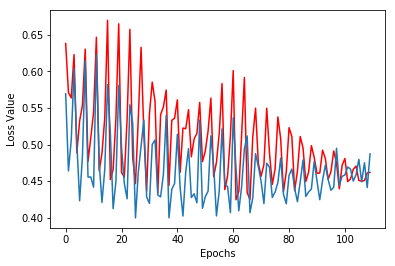

In [75]:
# plot the loss
# DON'T run this if you just test
plt.plot(train_losses, 'red')
plt.plot(test_losses)
#plt.ylim(0.0, 0.02)
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.show()

In [60]:
saver.save(session, save_path)

'model/lstm_ms_100hiddenneurons'

In [61]:
# load the saved model
saver.restore(session, save_path)

INFO:tensorflow:Restoring parameters from model/lstm_ms_100hiddenneurons


In [73]:
# try test the model
x_batch, y_batch = next(test_generator['lbkbls'])
feed_dict = {}
feed_dict[residualLSTM.input_feature_placeholder] = x_batch
res = session.run(out, feed_dict=feed_dict)

# inverse the result
result = q_pt['lbkbls'].inverse_transform(res[0][:])
true = q_pt['lbkbls'].inverse_transform(y_batch[0][:])

print ('Error by value:', np.mean(np.array(abs(result - true))))
print ('Error by Persentage:', np.mean(np.array(abs(result - true)/true)))

Error by value: 51.46922
Error by Persentage: 0.31937015


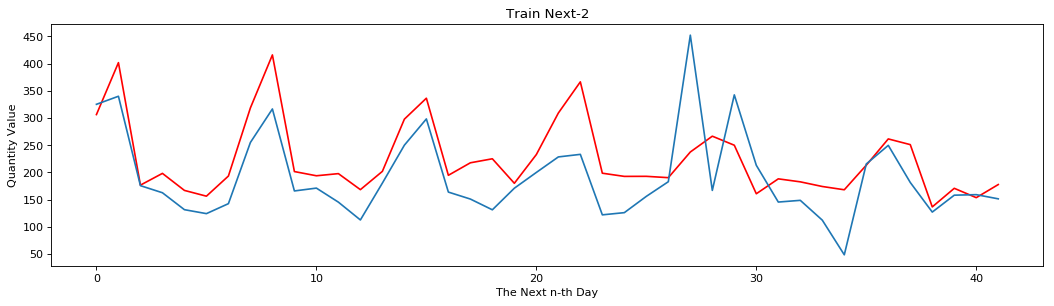

In [74]:
# plot the test result
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(result,'red')
plt.plot(true)
#plt.ylim(0, 1)
plt.ylabel('Quantity Value')
plt.xlabel('The Next n-th Day')
plt.title('Train Next-2')
plt.show()

In [76]:
def predict_all_test(lstm_seq, prediction_num, store_name='kmtjti'):
    res = []
    true = []
    length = len(y_test[store_name])
    iteration = int((length - (lstm_seq-7))/prediction_num)
    for i in range (iteration):
        x = np.array(x_test[store_name][i*prediction_num : i*prediction_num + lstm_seq])
        x = x.reshape((1, lstm_seq, 13))
        y = y_test[store_name][i*prediction_num : i*prediction_num + lstm_seq]
        y = list(itertools.chain(*y))
        feed_dict = {}
        feed_dict[residualLSTM.input_feature_placeholder] = x
        tmp_res = session.run(out, feed_dict=feed_dict)
        res.extend(list(itertools.chain(*tmp_res[0]))[-7:])
        true.extend(y[-7:])
        
    res = np.array(res)
    res = res.reshape((1, res.shape[0], 1))
    
    true = np.array(true)
    true = true.reshape((1, true.shape[0], 1))
    
    return np.array(res), np.array(true)

In [77]:
def calculate_loss(pred, true, scale=1):
    pred = np.array(pred)
    true = np.array(true)
    mape = abs((pred-true)/(true + 0.001))
    mape = np.mean(mape)
    
    error = np.mean(np.abs(pred - true))
    error = error * scale
    print ('Persentge Error: ', mape, ' , ', 'Quantity Error: ',  error)

In [78]:
results = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}
true_res = {'bmlbks': None, 'bsdtgr':None, 'cpkmas': None, 'cpkpth':None, 'dpkrgn':None, 
           'kmtjti': None, 'lbkbls':None, 'mgddua': None, 'mllind':None, 'pmthju':None, 
           'tmnmni': None, 'tmnplm':None, 'bkssqr': None, 'blkem':None, 'buaran':None,
           'cibnong':None, 'ciptat':None, 'ctrprk': None, 'epmpml':None, 'krwang':None,
           'ssncty': None, 'krwaci':None, 'cpnimal':None, 'cbncml':None, 'ksblnk':None,
           'tgrctr': None, 'tgrcty':None, 'pdkgde': None, 'xmall': None, 'cdkmll':None}

In [79]:
for i in pd_dict:
    if i != 'pdkgde':
        res, true = predict_all_test(lstm_seq=42, prediction_num=7, store_name=i)
        res = q_pt[i].inverse_transform(res[0][:])
        true = q_pt[i].inverse_transform(true[0][:])
        results[i]=res[:]
        true_res[i]=true[:]
        print ('Store Name: ', i)
        calculate_loss(res[:], true[:])

Store Name:  bmlbks
Persentge Error:  0.23320473898805855  ,  Quantity Error:  16.912321792404367
Store Name:  bsdtgr
Persentge Error:  0.2489318441987805  ,  Quantity Error:  17.772013467367582
Store Name:  cpkmas
Persentge Error:  0.19254148004927094  ,  Quantity Error:  19.221720432033784
Store Name:  cpkpth
Persentge Error:  0.31534967121910223  ,  Quantity Error:  28.015523391525488
Store Name:  dpkrgn
Persentge Error:  0.254005219438631  ,  Quantity Error:  20.76599892831778
Store Name:  kmtjti
Persentge Error:  0.30174347863038964  ,  Quantity Error:  26.34916251046316
Store Name:  lbkbls
Persentge Error:  0.24422122220760906  ,  Quantity Error:  40.24097986156909
Store Name:  mgddua
Persentge Error:  0.275834859362577  ,  Quantity Error:  17.256628529338094
Store Name:  mllind
Persentge Error:  0.41418050418441055  ,  Quantity Error:  24.660128604244875
Store Name:  pmthju
Persentge Error:  0.13638113625153642  ,  Quantity Error:  18.679293322278323
Store Name:  tmnmni
Persentg

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


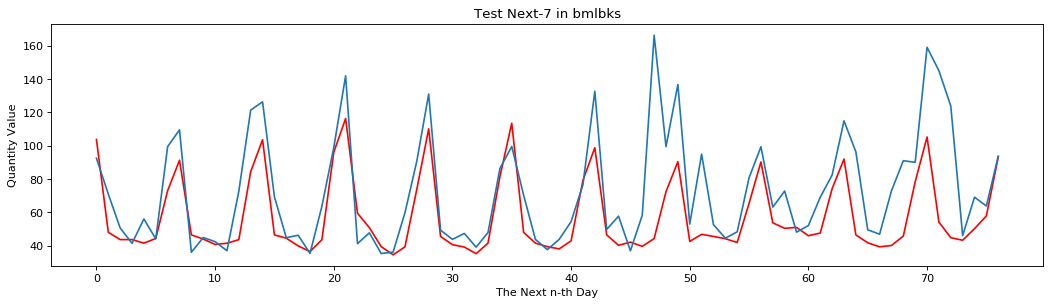

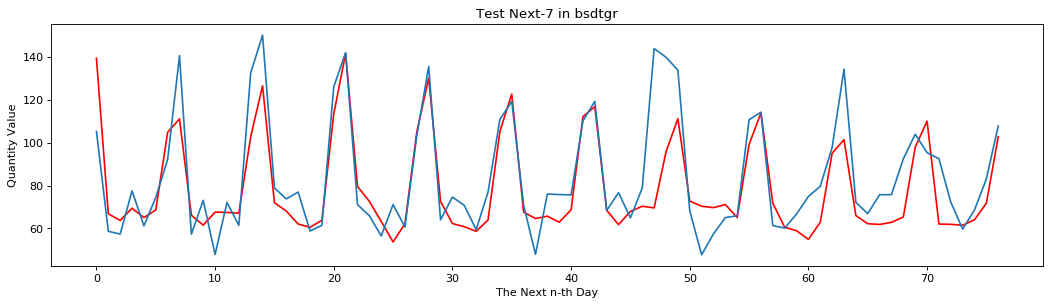

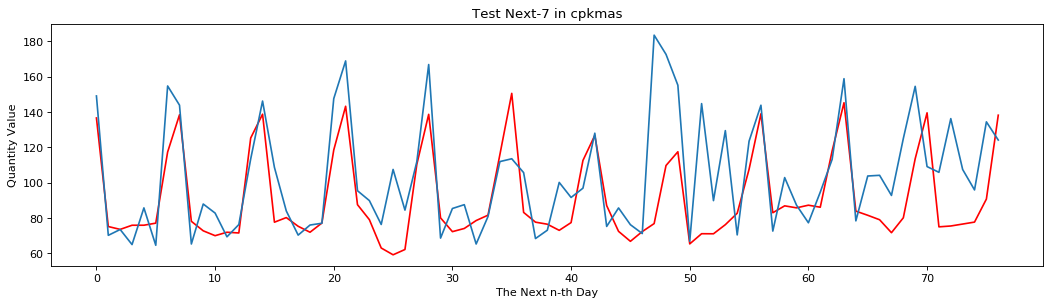

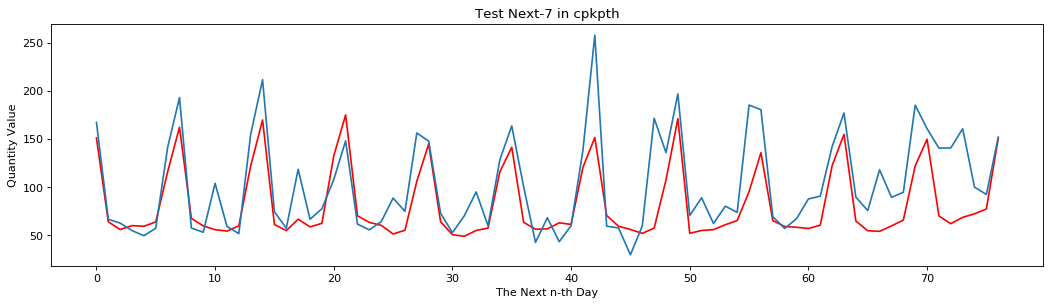

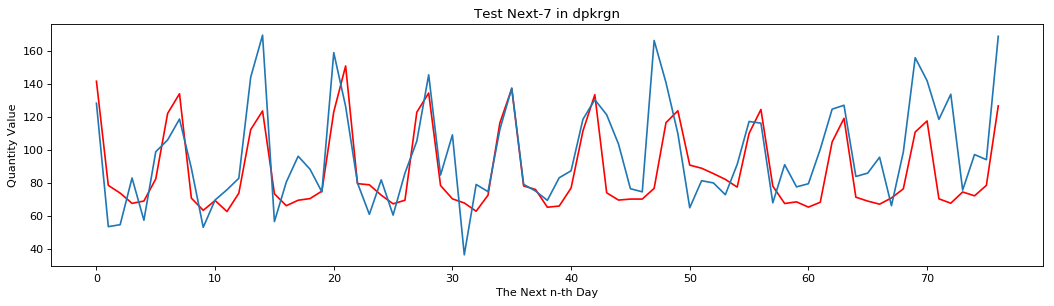

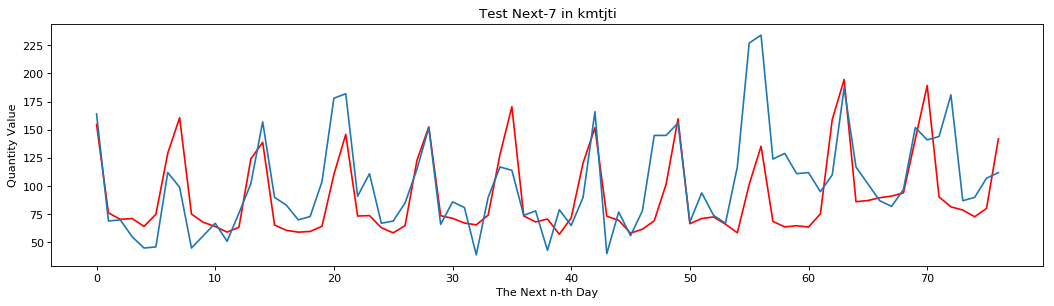

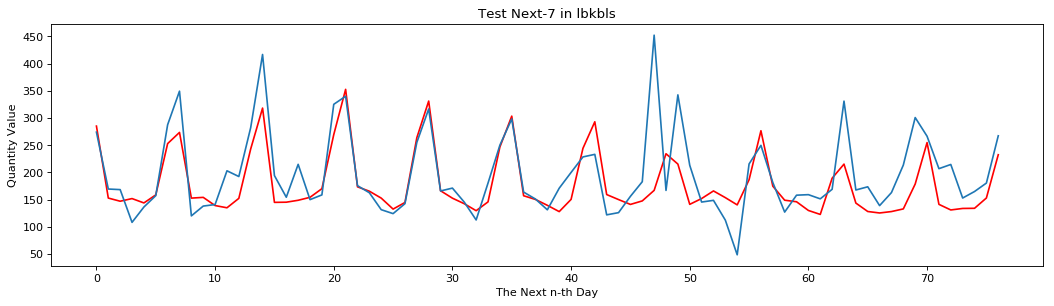

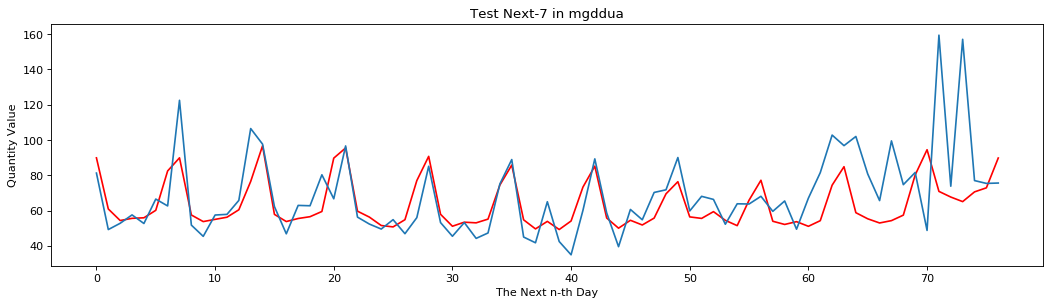

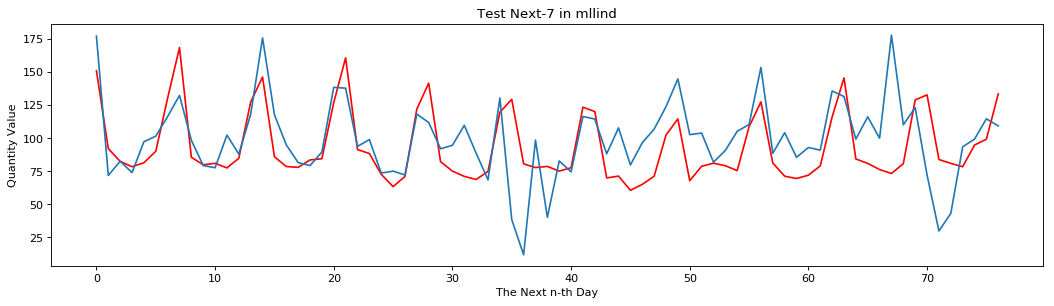

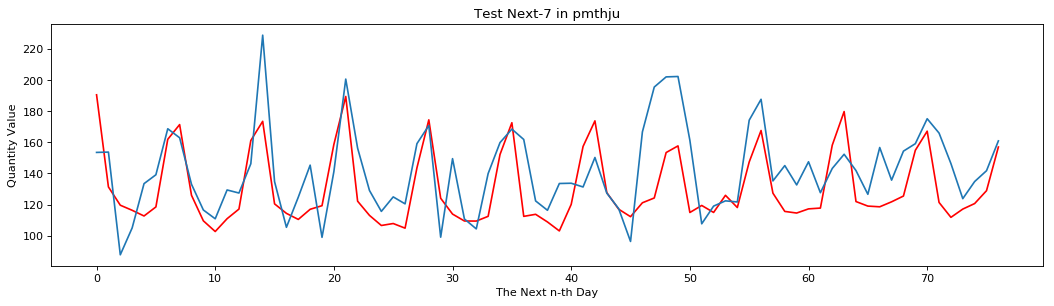

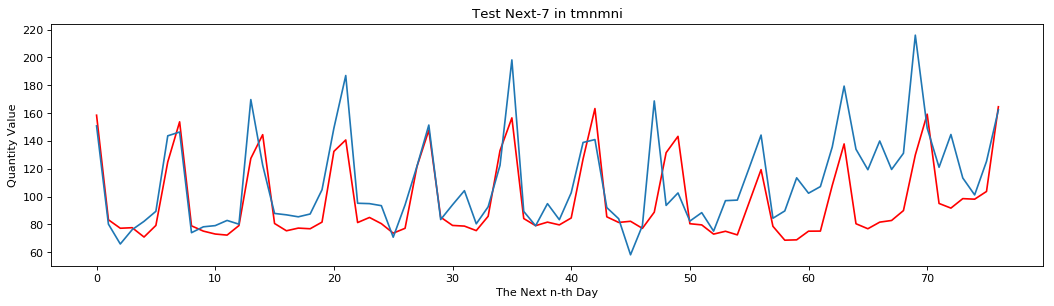

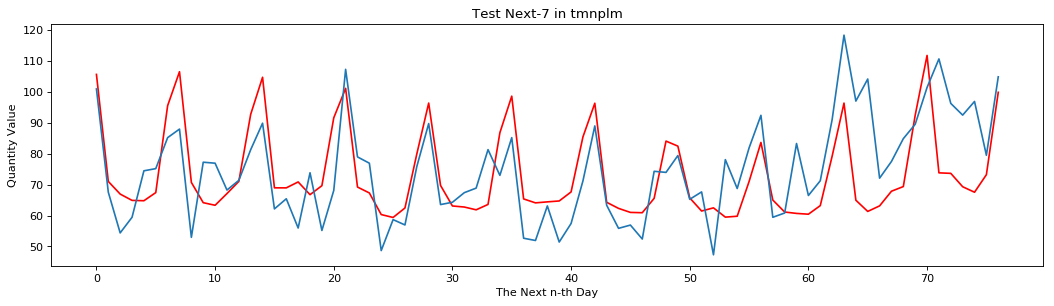

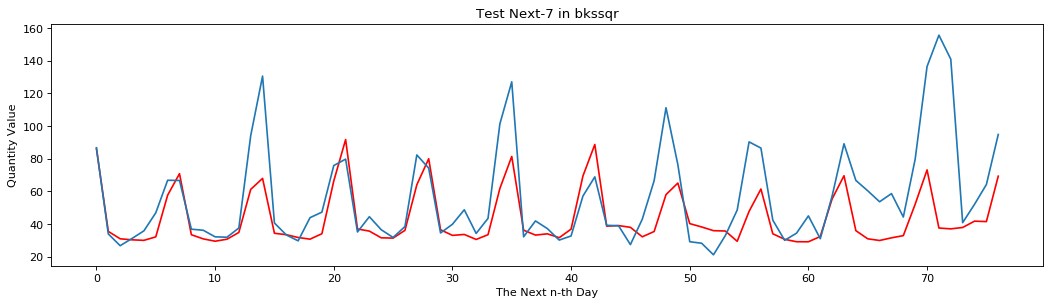

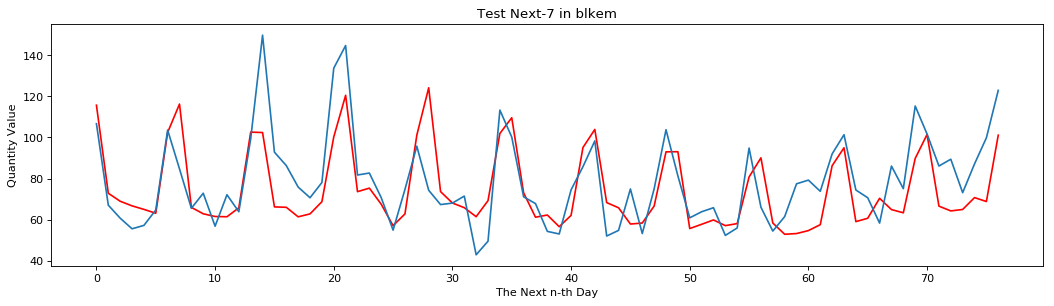

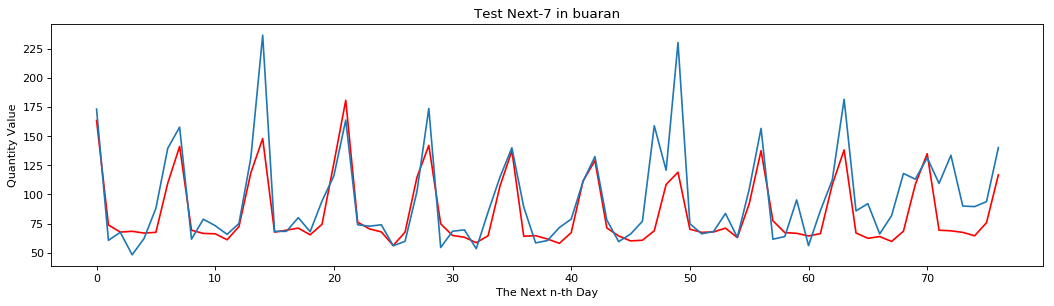

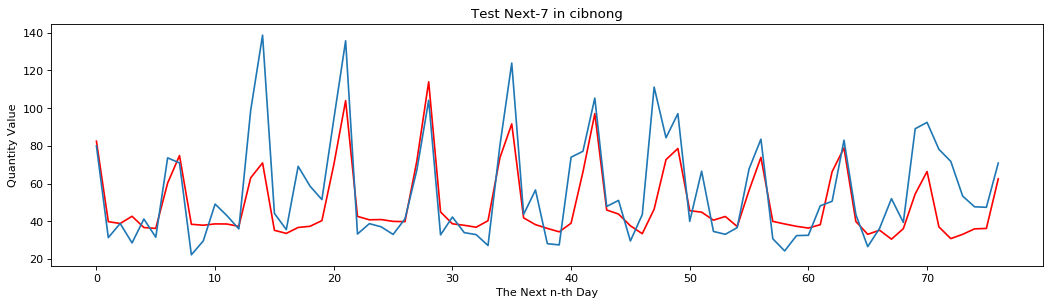

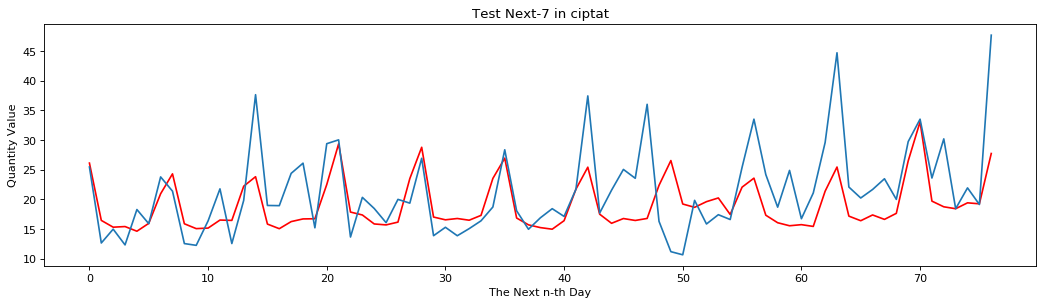

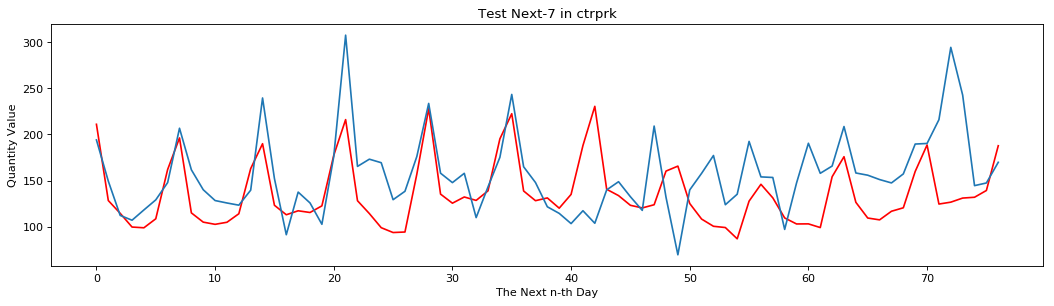

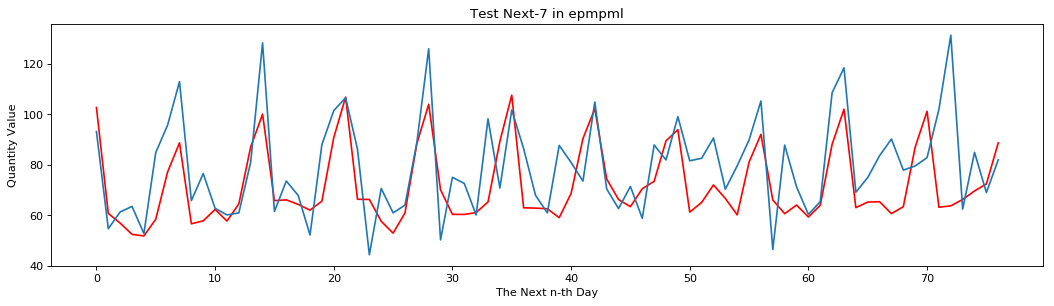

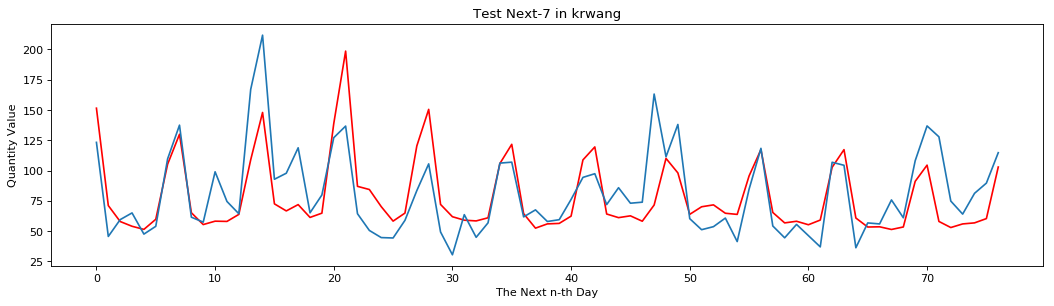

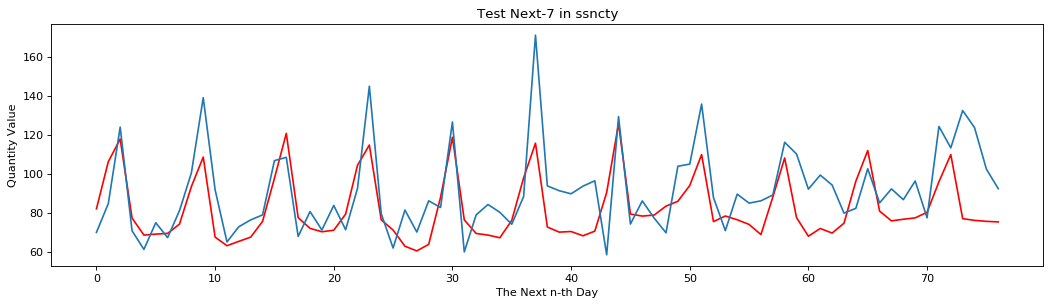

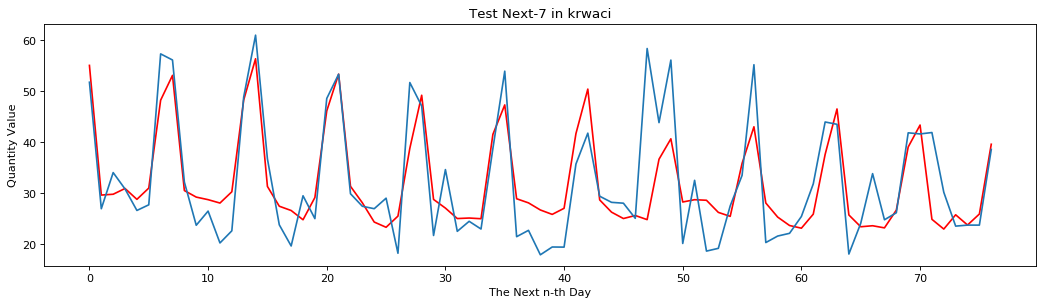

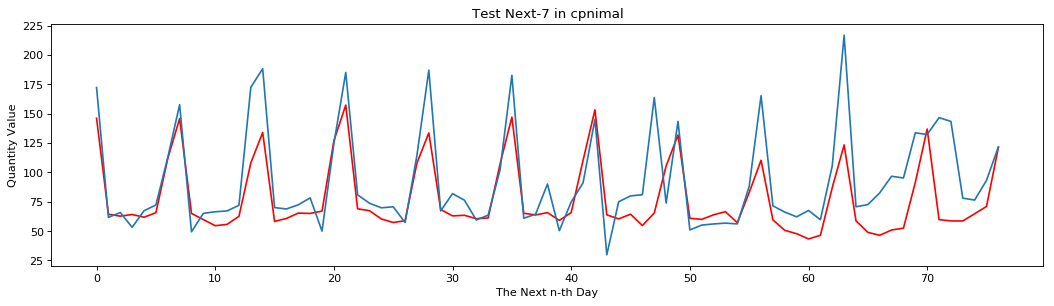

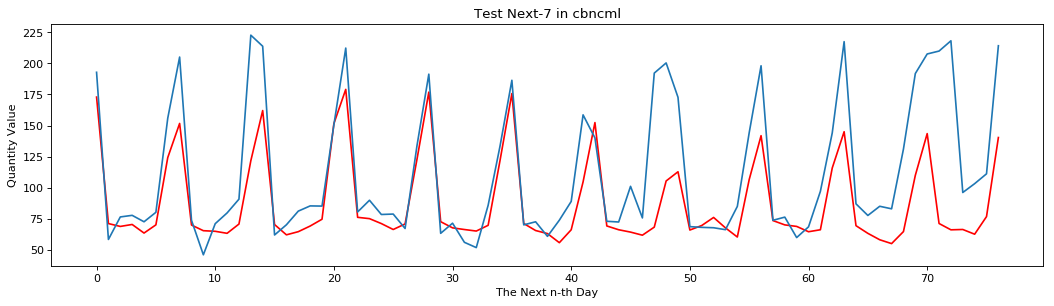

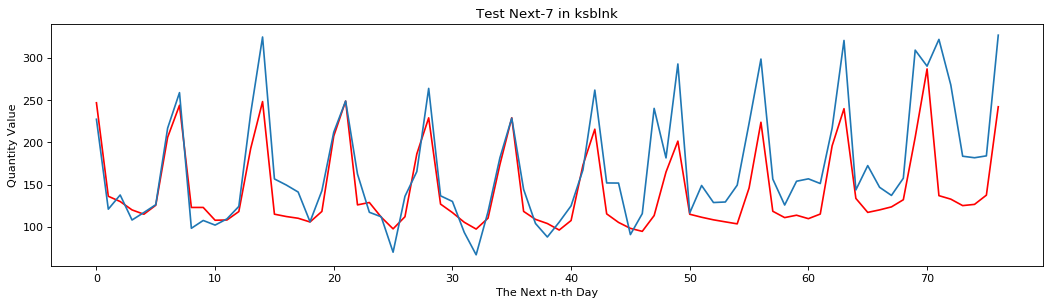

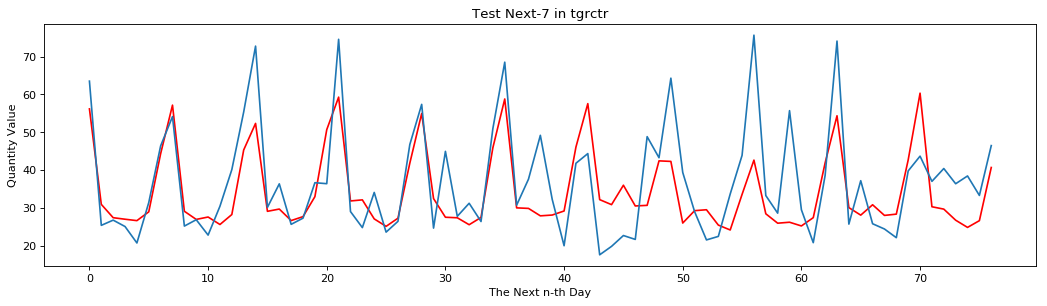

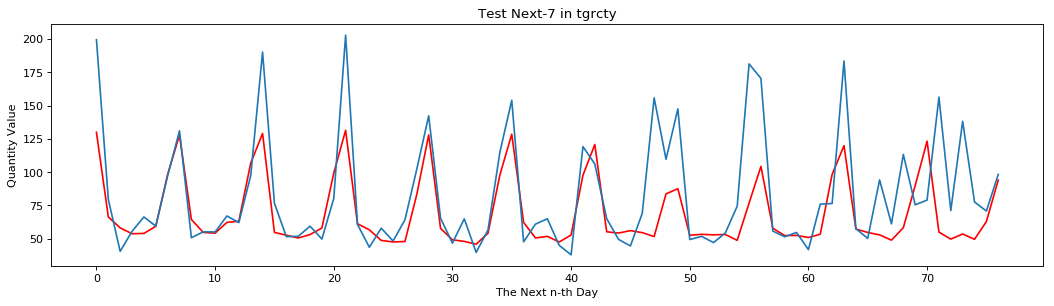

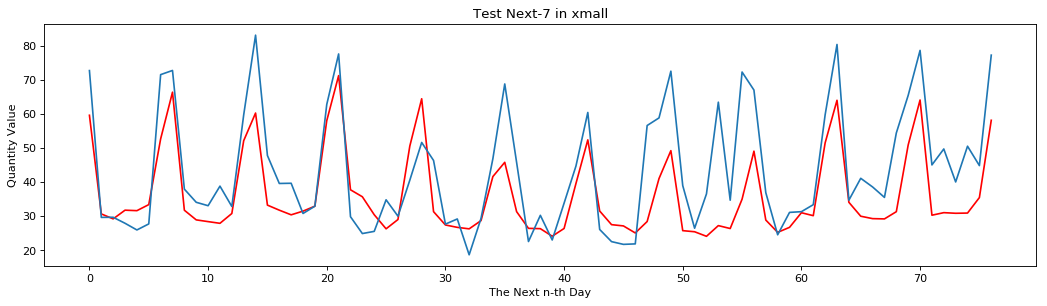

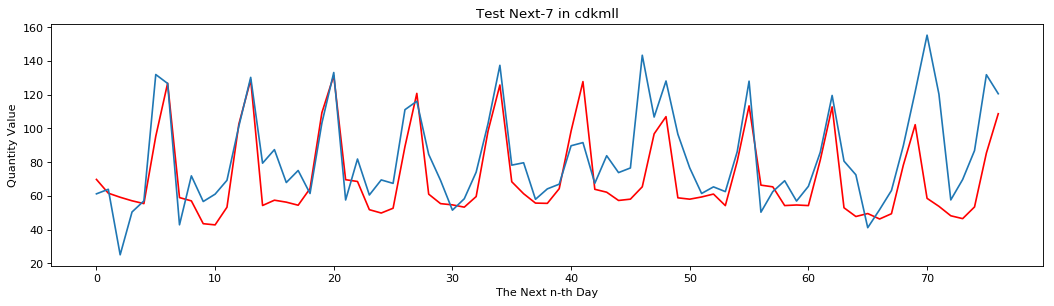

In [99]:
for i in pd_dict: 
    if i != 'pdkgde':
        figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(results[i],'red')
        plt.plot(true_res[i])
        #plt.ylim(20, 500)
        plt.ylabel('Quantity Value')
        plt.xlabel('The Next n-th Day')
        plt.title('Test Next-7 in ' + i)
plt.show()

In [39]:
lbkbls_2018 = pd.read_csv('../../dataset/egg/test_2018.csv', delimiter=',')
lbkbls_2018 = lbkbls_2018.reset_index(drop=True)
print (lbkbls_2018.shape)

(79, 10)


In [40]:
lbkbls_2018.head()

,Quantity,Price,Year,Month,Date,Day,Day_Multiple,PubHol,Weekend,Weekday
0,243.958,22300,2018,6,6,157,887,0,0,3
1,269.006,22300,2018,6,7,158,888,0,0,4
2,336.642,22300,2018,6,8,159,889,0,0,5
3,378.138,22300,2018,6,9,160,890,0,1,6
4,351.690,22300,2018,6,10,161,891,1,1,7


In [41]:
lbkbls_2018 = lbkbls_2018.rename(columns = {'Day': 'EncodedDate', 'PubHol': 'Is_holiday',\
                                              'Weekend':'Is_weekend', 'Weekday':'EncodedDay_week'})

In [42]:
lbkbls_2018 = lbkbls_2018.drop(['Day_Multiple'], axis=1)
lbkbls_2018.head()

,Quantity,Price,Year,Month,Date,EncodedDate,Is_holiday,Is_weekend,EncodedDay_week
0,243.958,22300,2018,6,6,157,0,0,3
1,269.006,22300,2018,6,7,158,0,0,4
2,336.642,22300,2018,6,8,159,0,0,5
3,378.138,22300,2018,6,9,160,0,1,6
4,351.690,22300,2018,6,10,161,1,1,7


In [43]:
lbkbls_2018['Quantity_dif'] = lbkbls_2018['Quantity'].diff()
lbkbls_2018['Quantity_dif2'] = lbkbls_2018['Quantity'].diff(periods=2)
lbkbls_2018['Quantity_dif3'] = lbkbls_2018['Quantity'].diff(periods=3)

lbkbls_2018['Price_dif'] = lbkbls_2018['Price'].diff()
lbkbls_2018['Price_dif2'] = lbkbls_2018['Price'].diff(periods=2)
lbkbls_2018['Price_dif3'] = lbkbls_2018['Price'].diff(periods=3)
    
lbkbls_2018['Level'] = lbkbls_2018['Quantity'].rolling(7).mean()
lbkbls_2018 = lbkbls_2018[7:]

In [44]:
lbkbls_2018.head()

,Quantity,Price,Year,Month,Date,EncodedDate,Is_holiday,Is_weekend,EncodedDay_week,Quantity_dif,Quantity_dif2,Quantity_dif3,Price_dif,Price_dif2,Price_dif3,Level
7,335.786,22300,2018,6,13,164,1,0,3,-39.003,-22.490,-15.904,0.0,0.0,0.0,343.475286
8,209.630,22300,2018,6,14,165,1,0,4,-126.156,-165.159,-148.646,0.0,0.0,0.0,334.993000
9,146.673,22300,2018,6,15,166,1,0,5,-62.957,-189.113,-228.116,0.0,0.0,0.0,307.854571
10,191.820,22300,2018,6,16,167,1,1,6,45.147,-17.810,-143.966,0.0,0.0,0.0,281.237714
11,189.454,22300,2018,6,17,168,0,1,7,-2.366,42.781,-20.176,0.0,0.0,0.0,258.061143


In [45]:
# prepare quantity data
quantity_np = np.array(lbkbls_2018['Quantity'])
quantity_np = np.abs(quantity_np.reshape((quantity_np.shape[0], 1)))
quantity_np += decay

# prepare level data
level_np = np.array(lbkbls_2018['Level'])
level_np = np.abs(level_np.reshape((level_np.shape[0], 1)))
level_np += decay

# fit and scale price data
#p_pt[i].fit(price_np)
#res = p_pt[i].transform(price_np)
#res = res.reshape((res.shape[0],))
#pd_dict[i]['Price'] = res
lbkbls_2018['Price'] = (lbkbls_2018['Price'] - price_scale_min)/(price_scale_max - price_scale_min)

# fit and scale quantity data
#q_pt[i].fit(quantity_np)
res = q_pt['lbkbls'].transform(quantity_np)
res = res.reshape((res.shape[0],))
lbkbls_2018['Quantity'] = res

# fit and transform level data
#l_pt[i].fit(level_np)
res = l_pt['lbkbls'].transform(level_np)
res = res.reshape((res.shape[0],))
lbkbls_2018['Level'] = res

lbkbls_2018['Quantity_dif'] = lbkbls_2018['Quantity_dif']/quantitydif_scale
lbkbls_2018['Quantity_dif2'] = lbkbls_2018['Quantity_dif2']/quantitydif_scale 
lbkbls_2018['Quantity_dif3'] = lbkbls_2018['Quantity_dif3']/quantitydif_scale

lbkbls_2018['Price_dif'] = lbkbls_2018['Price_dif']/pricedif_scale
lbkbls_2018['Price_dif2'] = lbkbls_2018['Price_dif2']/pricedif_scale
lbkbls_2018['Price_dif3'] = lbkbls_2018['Price_dif3']/pricedif_scale

lbkbls_2018['EncodedDay_week'] = lbkbls_2018['EncodedDay_week']/week_scale
lbkbls_2018['Date'] = lbkbls_2018['Date']/date_scale

In [46]:
print (lbkbls_2018.shape)
lbkbls_2018.head()

(72, 16)


,Quantity,Price,Year,Month,Date,EncodedDate,Is_holiday,Is_weekend,EncodedDay_week,Quantity_dif,Quantity_dif2,Quantity_dif3,Price_dif,Price_dif2,Price_dif3,Level
7,1.259180,0.486667,2018,6,0.419355,164,1,0,0.428571,-0.078006,-0.044980,-0.031808,0.0,0.0,0.0,2.227473
8,0.121380,0.486667,2018,6,0.451613,165,1,0,0.571429,-0.252312,-0.330318,-0.297292,0.0,0.0,0.0,2.130919
9,-0.837263,0.486667,2018,6,0.483871,166,1,0,0.714286,-0.125914,-0.378226,-0.456232,0.0,0.0,0.0,1.787491
10,-0.109190,0.486667,2018,6,0.516129,167,1,1,0.857143,0.090294,-0.035620,-0.287932,0.0,0.0,0.0,1.388709
11,-0.141831,0.486667,2018,6,0.548387,168,0,1,1.000000,-0.004732,0.085562,-0.040352,0.0,0.0,0.0,0.977213


In [47]:
targets_2018 = lbkbls_2018['Quantity'][7:]
features_2018 = lbkbls_2018[['Price', 'Quantity', 'Quantity_dif', 'Quantity_dif2', 'Quantity_dif3', 
                             'Price_dif', 'Price_dif2', 'Price_dif3', 'Level',
                             'Date', 'Is_holiday', 'Is_weekend', 'EncodedDay_week']][:-7]

In [48]:
features_np_2018 = features_2018.as_matrix().astype(float)
target_np_2018 = targets_2018.as_matrix().astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [49]:
def test_2018(lstm_seq, prediction_num):
    res = []
    true = []
    length = len(target_np_2018)
    iteration = int((length - (lstm_seq-7))/prediction_num)
    print (length, iteration)
    for i in range (iteration):
        x = np.array(features_np_2018[i*prediction_num : i*prediction_num + lstm_seq])
        x = x.reshape((1, lstm_seq, 13))
        y = target_np_2018 [i*prediction_num : i*prediction_num + lstm_seq]
        #y = list(itertools.chain(*y))
        feed_dict = {}
        feed_dict[residualLSTM.input_feature_placeholder] = x
        tmp_res = session.run(out, feed_dict=feed_dict)
        res.extend(list(itertools.chain(*tmp_res[0]))[-7:])
        true.extend(y[-7:])
        
    res = np.array(res)
    res = res.reshape((1, res.shape[0], 1))
    
    true = np.array(true)
    true = true.reshape((1, true.shape[0], 1))
    
    return np.array(res), np.array(true)

In [80]:
res, true = test_2018(lstm_seq=42, prediction_num=7)
res = q_pt['lbkbls'].inverse_transform(res[0][:])
true = q_pt['lbkbls'].inverse_transform(true[0][:])
results = res[7:]
true_res = true[7:]
print (results.shape)
print ('======', 'lbkbls')
calculate_loss(results, true_res)

65 4
(21, 1)
====== lbkbls
Persentge Error:  0.25711484744312124  ,  Quantity Error:  44.96725478980657


In [55]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(results,'red')
plt.plot(true_res)
plt.ylim(0, 400)
plt.ylabel('Quantity Value')
plt.xlabel('The Next n-th Day')
plt.title('Test Next-7 in ' + 'lebak bulus')
plt.show()

NameError: name 'figure' is not defined

In [67]:
print (results.reshape(results.shape[0]), true_res.reshape((true_res.shape[0])))

[157.05498  160.08153  181.04526  343.2441   345.29324  178.97623
 162.9311   137.1436   131.83702  159.96481  235.11325  241.84157
 155.9261   145.3202   123.643295 138.76088  146.55267  223.96544
 281.65015  156.6966   143.30815 ] [155.512 150.486 223.76  264.12  199.258 170.56  156.826 110.394 205.464
 189.7   259.104 300.468 180.368 139.884 139.262 131.438 296.968 277.78
 203.756 207.302 169.662]


In [68]:
np.savetxt('prediction_morehidden.csv', results.reshape((results.shape[0])), delimiter='\t')
np.savetxt('target_morehidden.csv', true_res.reshape((true_res.shape[0])), delimiter='\t')